# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [ ]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2022-10-06 05:53:43--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2022-10-06 05:53:43 (47.3 MB/s) - ‘cifar.py’ saved [2396/2396]



In [ ]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


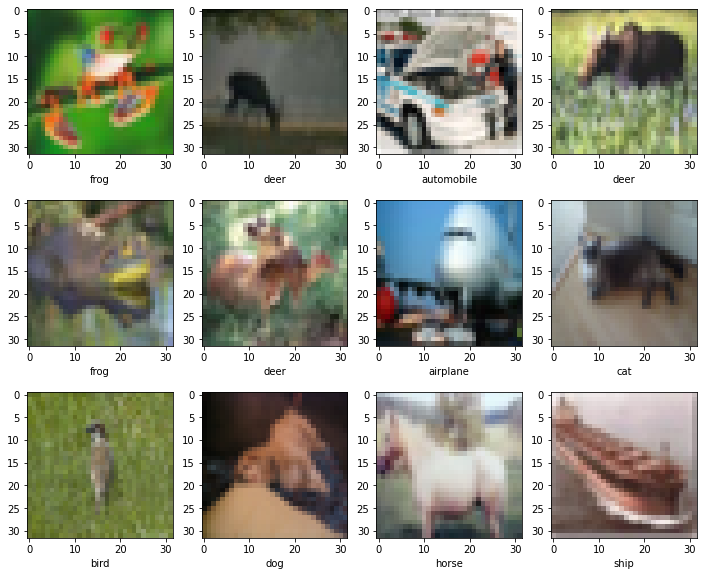

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [ ]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    #y_batch = torch.unsqueeze(y_batch,0)
    # X_batch = torch.unsqueeze(X_batch,0)
    # X_batch = torch.unsqueeze(X_batch,0)
    # y_batch = torch.unsqueeze(y_batch,0)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.2016, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [ ]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [ ]:
import time
num_epochs = 10 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 10 took 3.369s
  training loss (in-iteration): 	2.039824
  validation accuracy: 			33.80 %
Epoch 2 of 10 took 1.959s
  training loss (in-iteration): 	1.855112
  validation accuracy: 			36.82 %
Epoch 3 of 10 took 1.967s
  training loss (in-iteration): 	1.783619
  validation accuracy: 			38.23 %
Epoch 4 of 10 took 1.984s
  training loss (in-iteration): 	1.738509
  validation accuracy: 			39.51 %
Epoch 5 of 10 took 1.946s
  training loss (in-iteration): 	1.703017
  validation accuracy: 			41.13 %
Epoch 6 of 10 took 1.973s
  training loss (in-iteration): 	1.671341
  validation accuracy: 			42.43 %
Epoch 7 of 10 took 1.965s
  training loss (in-iteration): 	1.642483
  validation accuracy: 			43.19 %
Epoch 8 of 10 took 2.127s
  training loss (in-iteration): 	1.618399
  validation accuracy: 			43.75 %
Epoch 9 of 10 took 1.994s
  training loss (in-iteration): 	1.593993
  validation accuracy: 			43.27 %
Epoch 10 of 10 took 1.973s
  training loss (in-iteration): 	1.577602
  validation 

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		43.57 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2), 
    nn.Flatten(),
    nn.Linear(2250, 300),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.Dropout(p=0.1),              
)

opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [ ]:

X_batch.shape

(500, 3, 32, 32)

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    #y_batch = torch.unsqueeze(y_batch,0)
    # X_batch = torch.unsqueeze(X_batch,0)
    # X_batch = torch.unsqueeze(X_batch,0)
    # y_batch = torch.unsqueeze(y_batch,0)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
import time
num_epochs = 10 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 10 took 14.536s
  training loss (in-iteration): 	2.549541
  validation accuracy: 			27.97 %
Epoch 2 of 10 took 15.941s
  training loss (in-iteration): 	2.230960
  validation accuracy: 			31.58 %
Epoch 3 of 10 took 14.398s
  training loss (in-iteration): 	2.117458
  validation accuracy: 			38.58 %
Epoch 4 of 10 took 13.286s
  training loss (in-iteration): 	2.024848
  validation accuracy: 			40.40 %
Epoch 5 of 10 took 13.941s
  training loss (in-iteration): 	1.949446
  validation accuracy: 			40.00 %
Epoch 6 of 10 took 15.218s
  training loss (in-iteration): 	1.889360
  validation accuracy: 			45.98 %
Epoch 7 of 10 took 19.695s
  training loss (in-iteration): 	1.842765
  validation accuracy: 			46.73 %
Epoch 8 of 10 took 13.856s
  training loss (in-iteration): 	1.786529
  validation accuracy: 			49.75 %
Epoch 9 of 10 took 13.805s
  training loss (in-iteration): 	1.738401
  validation accuracy: 			48.59 %
Epoch 10 of 10 took 14.725s
  training loss (in-iteration): 	1.683839
  v

```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.BatchNorm2d(10),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2), 
    nn.Flatten(),
    nn.Linear(2250, 300),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.Dropout(p=0.1),              
)

opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [ ]:
import time
num_epochs = 10 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_batch) // batch_size :]) * 100))

Epoch 1 of 10 took 15.270s
  training loss (in-iteration): 	2.119920
  validation accuracy: 			42.00 %
Epoch 2 of 10 took 15.198s
  training loss (in-iteration): 	1.737463
  validation accuracy: 			50.00 %
Epoch 3 of 10 took 16.038s
  training loss (in-iteration): 	1.611557
  validation accuracy: 			52.00 %


KeyboardInterrupt: ignored


```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [ ]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [ ]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


NotImplementedError: ignored

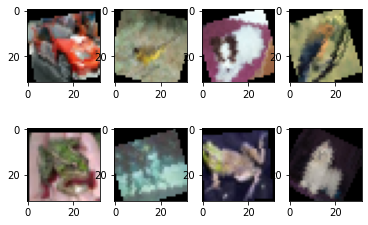

In [ ]:

for (x_batch, y_batch) in train_batch_gen:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
        
    
    raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

When testing, we don't need random crops, just normalize with same statistics.

X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


NotImplementedError: ignored

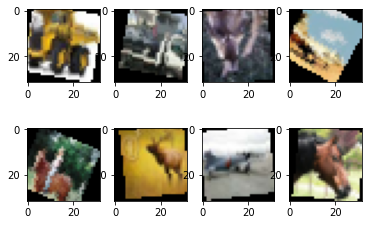

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_augment)

test_batch_gen = torch.utils.data.DataLoader(test_loader, 
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1) 

for (x_batch, y_batch) in test_batch_gen:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
        
    raise NotImplementedError("Plese use this code in your training loop")

# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


**Models training**

These are two attempts to achieve the highest accuracy on CIFAR10 dataset.

Spoiler: the maximum accuracy achieved is 72%

There is a short report about the work in the end.

In [ ]:
import torchvision
from torchvision import transforms

In [ ]:
transform_train = transforms.Compose([
   transforms.RandomCrop(32, padding=4),
   transforms.RandomRotation([-30, 30]),
   transforms.RandomHorizontalFlip(),
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root="./cifar_data/", train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)


Files already downloaded and verified


In [ ]:
transform_test = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root="./cifar_data/", train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True, num_workers=2)


Files already downloaded and verified


In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3),
    nn.BatchNorm2d(20),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2), 
    nn.Flatten(),
    nn.Linear(1280, 500),
    nn.Tanh(),
    nn.Linear(500, 250), 
    nn.ReLU(),
    nn.Linear(250, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.Dropout(p=0.1)        
)

opt = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(opt, gamma=0.1, step_size=5)


criterion = nn.CrossEntropyLoss()

In [ ]:
import time
num_epochs = 30
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for epoch in range(num_epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (x_train, y_train) in trainloader:
        # train on batch
        outputs = model(x_train) # every batch of 100 images are put as an input.
        loss = criterion(outputs, y_train)
        loss.backward()
        opt.step()
        opt.zero_grad()
        _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
        running_loss += loss.item()
        running_corrects += torch.sum(preds == y_train.data)
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
      for (x_val, y_val) in testloader:
          y_out = model(torch.as_tensor(x_val, dtype=torch.float32))
          val_loss = criterion(y_out, y_val)
          _, y_pred = torch.max(y_out, 1)
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(y_pred == y_val.data)
    
    scheduler.step()
    
    epoch_loss = running_loss/len(trainloader) # loss per epoch
    epoch_acc = running_corrects.float()/ len(trainloader) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying 
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(testloader)
    val_epoch_acc = val_running_corrects.float()/len(testloader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))


Epoch 1 of 30 took 44.397s
epoch : 1
training loss: 1.8824, acc 30.9440 
validation loss: 1.6243, validation acc 39.4600 
Epoch 2 of 30 took 43.259s
epoch : 2
training loss: 1.7181, acc 38.0840 
validation loss: 1.4287, validation acc 48.2100 
Epoch 3 of 30 took 43.335s
epoch : 3
training loss: 1.6700, acc 40.5520 
validation loss: 1.3937, validation acc 50.4800 
Epoch 4 of 30 took 43.411s
epoch : 4
training loss: 1.6426, acc 41.5960 
validation loss: 1.4396, validation acc 48.7500 
Epoch 5 of 30 took 44.113s
epoch : 5
training loss: 1.6437, acc 41.7480 
validation loss: 1.4220, validation acc 50.6700 
Epoch 6 of 30 took 43.250s
epoch : 6
training loss: 1.4561, acc 47.8500 
validation loss: 1.1922, validation acc 57.7400 
Epoch 7 of 30 took 43.638s
epoch : 7
training loss: 1.4022, acc 49.8020 
validation loss: 1.1575, validation acc 58.6600 
Epoch 8 of 30 took 43.411s
epoch : 8
training loss: 1.3789, acc 50.6720 
validation loss: 1.1504, validation acc 58.9600 
Epoch 9 of 30 took 44.39

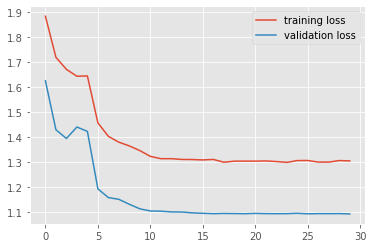

In [ ]:
    plt.style.use('ggplot')
    plt.plot(running_loss_history, label='training loss')
    plt.plot(val_running_loss_history, label='validation loss')
    plt.legend()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3),
    nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3),
    nn.BatchNorm2d(40),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2), 
    nn.MaxPool2d(kernel_size=2), 
    nn.Flatten(),
    nn.Linear(1440, 500),
    nn.ReLU(),
    nn.Linear(500, 250), 
    nn.ReLU(),
    nn.Linear(250, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.Dropout(p=0.1)        
)

model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.001)


criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 30
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for epoch in range(num_epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (x_train, y_train) in trainloader:
        # train on batch
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        outputs = model(x_train) # every batch of 100 images are put as an input.
        loss = criterion(outputs, y_train)
        loss.backward()
        opt.step()
        opt.zero_grad()
        _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
        running_loss += loss.item()
        running_corrects += torch.sum(preds == y_train.data)
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
      for (x_val, y_val) in testloader:
          x_val = x_val.to(device)
          y_val = y_val.to(device)
          y_out = model(torch.as_tensor(x_val, dtype=torch.float32))
          val_loss = criterion(y_out, y_val)
          _, y_pred = torch.max(y_out, 1)
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(y_pred == y_val.data)
    epoch_loss = running_loss/len(trainloader) # loss per epoch
    epoch_acc = running_corrects.float()/ len(trainloader) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying 
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(testloader)
    val_epoch_acc = val_running_corrects.float()/len(testloader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

Epoch 1 of 30 took 85.634s
epoch : 1
training loss: 1.7845, acc 34.6620 
validation loss: 1.4850, validation acc 46.2300 
Epoch 2 of 30 took 85.252s
epoch : 2
training loss: 1.5641, acc 43.7860 
validation loss: 1.2821, validation acc 54.4100 
Epoch 3 of 30 took 86.212s
epoch : 3
training loss: 1.4603, acc 47.5220 
validation loss: 1.2286, validation acc 56.5200 
Epoch 4 of 30 took 85.859s
epoch : 4
training loss: 1.3964, acc 50.2460 
validation loss: 1.1476, validation acc 59.6900 
Epoch 5 of 30 took 86.488s
epoch : 5
training loss: 1.3524, acc 51.7360 
validation loss: 1.1129, validation acc 61.2200 
Epoch 6 of 30 took 85.413s
epoch : 6
training loss: 1.3144, acc 53.2420 
validation loss: 1.0911, validation acc 62.7700 
Epoch 7 of 30 took 86.255s
epoch : 7
training loss: 1.2757, acc 54.5700 
validation loss: 1.0453, validation acc 63.1800 
Epoch 8 of 30 took 86.330s
epoch : 8
training loss: 1.2547, acc 55.2860 
validation loss: 0.9905, validation acc 65.7300 
Epoch 9 of 30 took 86.20

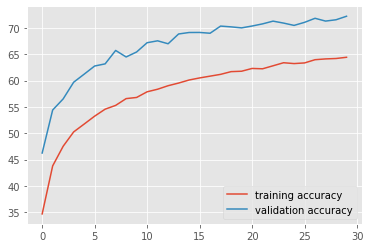

In [ ]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

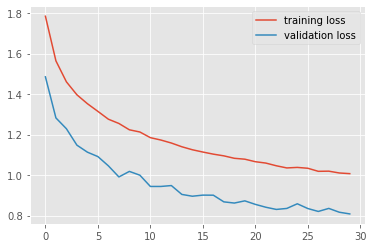

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

#Report

**Stage 1**

The first stage is preprocessing. So, the given images have to be transformed to tensors. In the provided model images for train set are randomly rotated, normalized and flipped. This way is provided to catch the main features of each class of the images. Finally, trainloader is tuned to output batches of the fixed size (100 samples).

**Stage 2**

The second stage includes building of a model, which will be trained. The most successful model consists from 4 layers. Convolution is performed by the 3 filters with size 3x3. Batch normalization is also included in the model for better quality and higher speed. Finally, maxpooling helps to decrease the number of neurons. Both convolution and maxpooling compress the images and detect important patterns. SGD with momentum was included as an optimizer. However, it was found that Adam is better for this task. Momentum is SGD helps to smooth accuracy dynamic. The optimal level of learning rate in Adam was 0.001 after experiments.

**Stage 3**

It is time for train and valuation. The train lasted 30 epochs. This is because an accuracy on the last 5 epochs is constant. Accuracy on validation is calculated as the number of the right classes among all test dataset. Loss function is cross entropy. After every epoch data about tha losses and accuracies on train and test are collected in the lists, and finally graphics are provided.

**P.S.** Some ideas are taken from the given sites:
* https://medium.com/@buiminhhien2k/solving-cifar10-dataset-with-vgg16-pre-trained-architect-using-pytorch-validation-accuracy-over-3f9596942861
* https://www.kaggle.com/code/vikasbhadoria/cifar10-high-accuracy-model-build-on-pytorch 